# Taller 3


In [1]:
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt

import numpy as np

from skimage import exposure
from skimage.util import random_noise
from skimage.filters import threshold_local
from skimage.segmentation import slic
from skimage.segmentation import flood
from skimage import segmentation

from sklearn.cluster import KMeans

## Ejercicio 1


In [2]:
img_1 = [
    Path("./img/1-thresholding/OBJECTS.png"),
    Path("./img/1-thresholding/Text.png"),
]

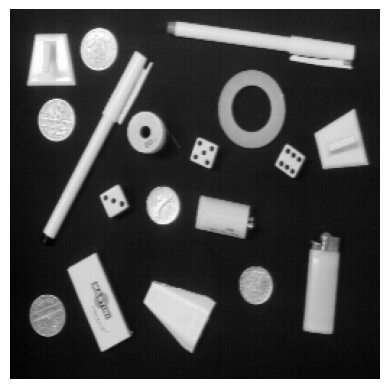

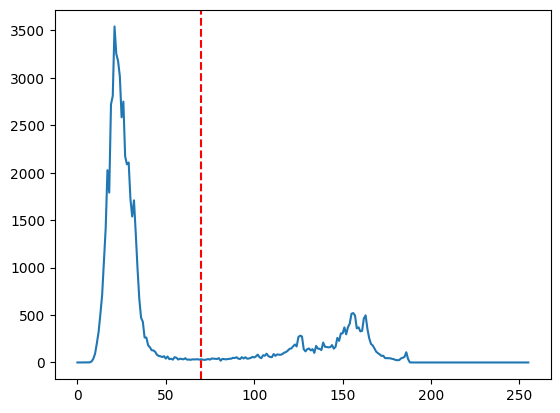

In [3]:
object_img = cv.imread(img_1[0], cv.IMREAD_GRAYSCALE)
plt.imshow(object_img, cmap="gray")
plt.axis("off")
plt.show()

max_x = 70
hist = cv.calcHist([object_img], [0], None, [256], [0, 256])
plt.plot(hist)
plt.axvline(x=max_x, color="r", linestyle="--")
plt.show()

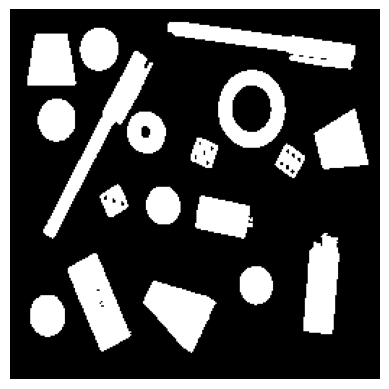

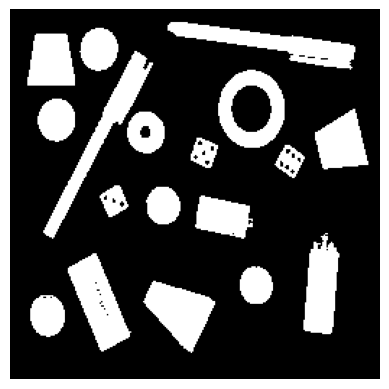

In [4]:
_, object_thresh_global = cv.threshold(object_img, max_x, 255, cv.THRESH_BINARY)
plt.imshow(object_thresh_global, cmap="gray")
plt.axis("off")
plt.show()

_, object_thresh_otsu = cv.threshold(
    object_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)
plt.imshow(object_thresh_otsu, cmap="gray")
plt.axis("off")
plt.show()

0.0 0.8023156021247037
0.0 1.0


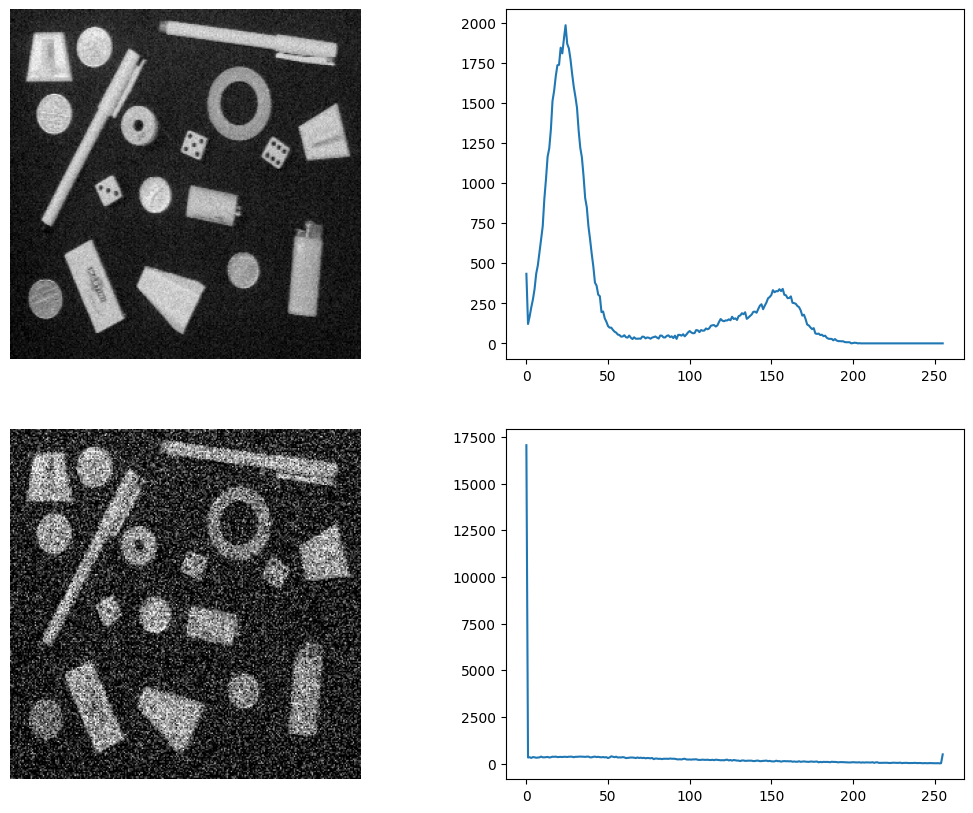

In [5]:
_, axes = plt.subplots(2, 2, figsize=(13, 10))

object_noise_001 = random_noise(object_img, mode="gaussian", mean=0, var=0.001)
print(object_noise_001.min(), object_noise_001.max())
object_noise_001 = (object_noise_001 * 255).astype(np.uint8)
axes[0, 0].imshow(object_noise_001, cmap="gray")
axes[0, 0].axis("off")
hist = cv.calcHist([object_noise_001], [0], None, [256], [0, 256])
axes[0, 1].plot(hist)

object_noise_05 = random_noise(object_img, mode="gaussian", mean=0, var=0.05)
print(object_noise_05.min(), object_noise_05.max())
object_noise_05 = (object_noise_05 * 255).astype(np.uint8)
axes[1, 0].imshow(object_noise_05, cmap="gray")
axes[1, 0].axis("off")
hist = cv.calcHist([object_noise_05], [0], None, [256], [0, 256])
axes[1, 1].plot(hist)


En el primer caso, cuando usamos una varianza de 0.001, observamos un ensanchamiento en los dos modos de la imágen. La imágen, que antes tenía una definición bastante buena, y se veía suave, ahora se ve granulada. El ruido ha generado un ligero desplazamiento en los grises que toman los pixeles.

En el segundo caso, en el que la varianza incrementa bastante, las fluctuaciones en los valores de grises de los píxeles es tan grande que un valor de gris $x$ casi seguramente pasa a $0$ o a $255$, casi sin tener en cuenta su valor inicial. La imágen ahora parece binaria y hay MUCHO ruído.


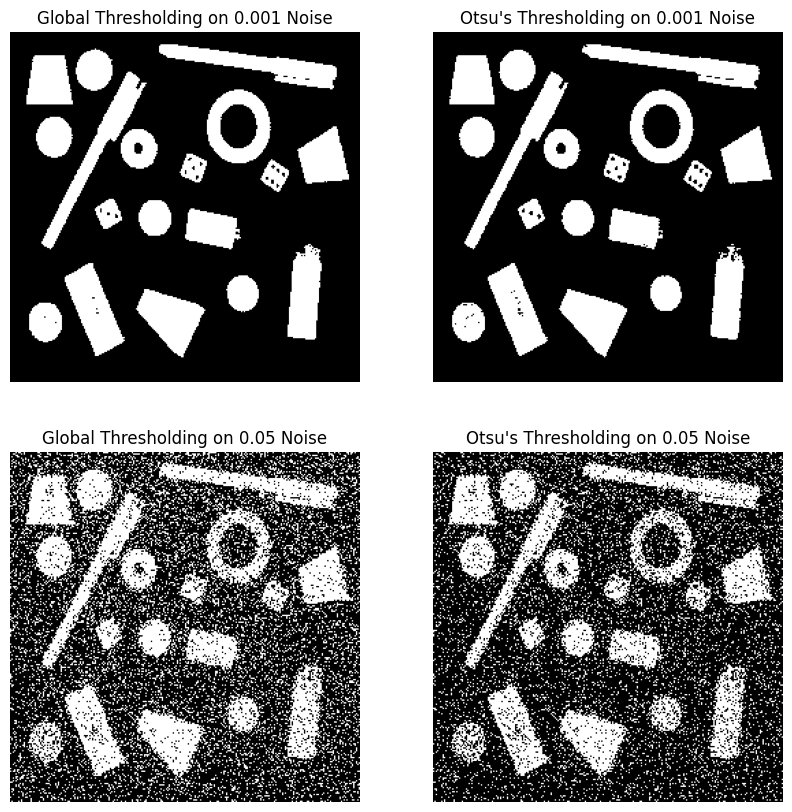

In [6]:
_, object_thresh_001 = cv.threshold(object_noise_001, max_x, 255, cv.THRESH_BINARY)
_, object_thresh_otsu_001 = cv.threshold(
    object_noise_001, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)

_, object_thresh_05 = cv.threshold(object_noise_05, max_x, 255, cv.THRESH_BINARY)
_, object_thresh_otsu_05 = cv.threshold(
    object_noise_05, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)

_, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(object_thresh_001, cmap="gray")
axes[0, 0].axis("off")
axes[0, 0].set_title("Global Thresholding on 0.001 Noise")
axes[0, 1].imshow(object_thresh_otsu_001, cmap="gray")
axes[0, 1].axis("off")
axes[0, 1].set_title("Otsu's Thresholding on 0.001 Noise")
axes[1, 0].imshow(object_thresh_05, cmap="gray")
axes[1, 0].axis("off")
axes[1, 0].set_title("Global Thresholding on 0.05 Noise")
axes[1, 1].imshow(object_thresh_otsu_05, cmap="gray")
axes[1, 1].axis("off")
axes[1, 1].set_title("Otsu's Thresholding on 0.05 Noise")
plt.show()


En el caso de ruido con varianza $0.001$, notamos que no ocurrieron cambios notables en la umbralización (con respecto a la realizada anteriormente). Esto se debe a que, si bien los dos modos en los histogramas se ensancharon, todavía son fácilmente diferenciables.

Por otro lado, cuando intentamos umbralizar la imágen con ruido con varianza $0.05$, vemos el ruído todavía presente en la imágen. Esto se debe a lo explicado anteriormente. pixeles que antes eran del modo negro ahora están más en el espectro de los grises claros, y viceversa.


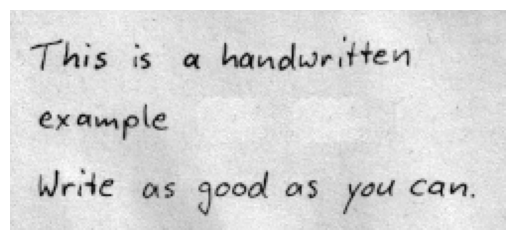

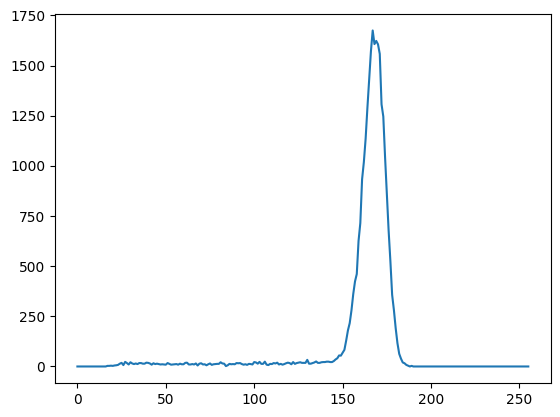

In [7]:
text_img = cv.imread(str(img_1[1]), cv.IMREAD_GRAYSCALE)
plt.imshow(text_img, cmap="gray")
plt.axis("off")
plt.show()

hist = cv.calcHist([text_img], [0], None, [256], [0, 256])
plt.plot(hist)
plt.show()

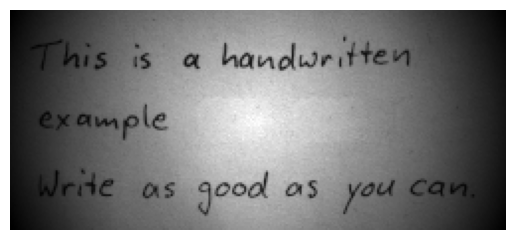

In [8]:
rows, cols = text_img.shape
x, y = np.meshgrid(np.arange(cols), np.arange(rows))
# Cálculo del centro
cx, cy = cols // 2, rows // 2
# Cálculo del radio y distancia posible
distance = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
max_dist = np.sqrt(cx**2 + cy**2)

# Aplicación del gradiente
spot_shading = 1 - (distance / max_dist)
spot_image = text_img * spot_shading

spot_image = spot_image.astype(np.uint8)

plt.imshow(spot_image, cmap="gray")
plt.axis("off")
plt.show()


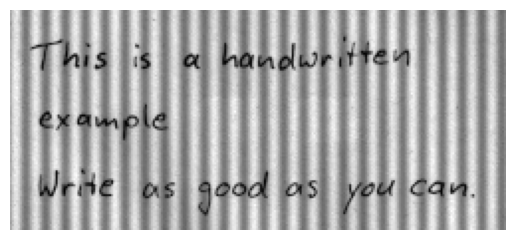

In [9]:
# Cantidad de perturbaciones
frequency = 10
# Intensidad de los picos
amplitude = 0.3

# Cálculo y aplicación del efecto
sinusoidal_shading = (1 + amplitude * np.sin(2 * np.pi * x / frequency)) / 1.5
sinusoidal_image = text_img * sinusoidal_shading

sinusoidal_image = sinusoidal_image.astype(np.uint8)

plt.imshow(sinusoidal_image, cmap="gray")
plt.axis("off")
plt.show()

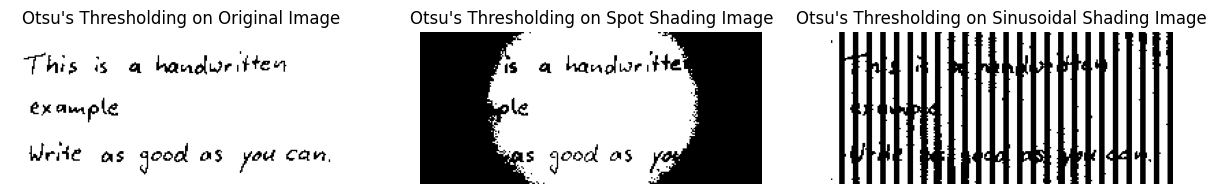

In [10]:
text_img_thresh_otsu = cv.threshold(
    text_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)[1]
spot_image_thresh_otsu = cv.threshold(
    spot_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)[1]
sinusoidal_image_thresh_otsu = cv.threshold(
    sinusoidal_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)[1]

fig_axes = plt.subplots(1, 3, figsize=(15, 5))[1]
fig_axes[0].imshow(text_img_thresh_otsu, cmap="gray")
fig_axes[0].axis("off")
fig_axes[0].set_title("Otsu's Thresholding on Original Image")
fig_axes[1].imshow(spot_image_thresh_otsu, cmap="gray")
fig_axes[1].axis("off")
fig_axes[1].set_title("Otsu's Thresholding on Spot Shading Image")
fig_axes[2].imshow(sinusoidal_image_thresh_otsu, cmap="gray")
fig_axes[2].axis("off")
fig_axes[2].set_title("Otsu's Thresholding on Sinusoidal Shading Image")
plt.show()

La umbralización no funciona muy bien en las imágenes con sombra, ni spot, ni sinusoidal. Esto ocurre porque la parte más afectada por el sombreado queda en la parte izquierda del umbral encontrado por otsu. Este problema se podría mitigar intentando aliminar la sombra. Se tendría que buscar iluminar la parte sombreada. O también se podría usar un thresholding diferente a otsu, en el que nosotros escojamos un umbral que le sirva a la imágen.


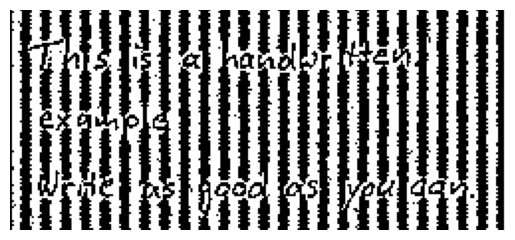

In [11]:
X = 5  # X = 5 mostró los mejores resultados
local_sinusoidal = threshold_local(sinusoidal_image, block_size=X, method="mean")
binary_local_sinusoidal = sinusoidal_image > local_sinusoidal
plt.imshow(binary_local_sinusoidal, cmap="gray")
plt.axis("off")
plt.show()

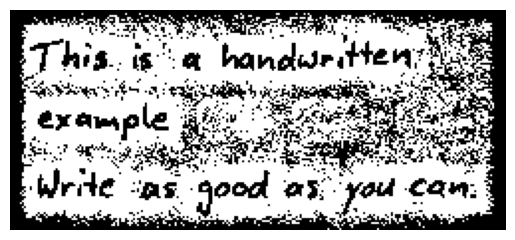

In [12]:
X = 21  # X = 21 mostró los mejores resultados
local_spot = threshold_local(spot_image, block_size=X, method="mean")
binary_local_spot = spot_image > local_spot
plt.imshow(binary_local_spot, cmap="gray")
plt.axis("off")
plt.show()

La umbralización realizada con este método da mejores resultados que la otsu. Con únicamente la umbralización otsu era ininteligible el mensaje completo, en ambos casos. Con este nuevo método, podemos leer el mensaje completo, sobretodo en el sinusoidal. Esto ayuda a mejorar los resultados de una umbralización final porque ahora que conocemos el mensaje completo, y cómo se ven las letras. Con esta información podríamos corregir el sombreado de la imágen de mejor manera, sabiendo qué es lo esperado.


## Ejercicio 2


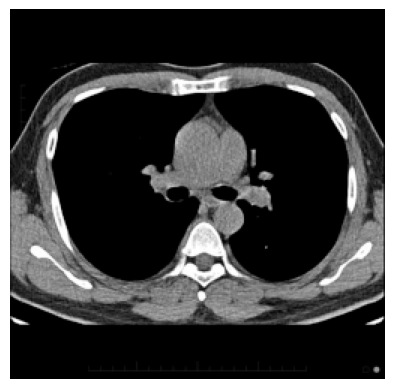

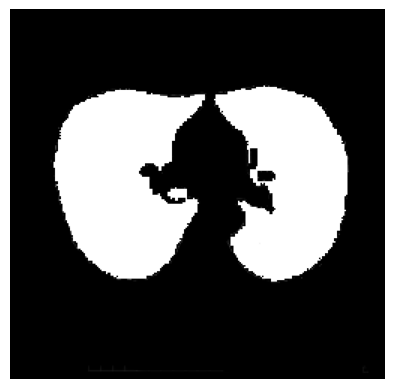

In [13]:
img_2 = [
    Path("./img/2-regions/CHEST.png"),
    Path("./img/2-regions/CHEST_MASK.png"),
]

for img_path in img_2:
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

In [14]:
chest = cv.imread(img_2[0], cv.IMREAD_GRAYSCALE)
chest_mask = cv.imread(img_2[1], cv.IMREAD_GRAYSCALE)

## Cero tolerancia


(np.float64(-0.5), np.float64(249.5), np.float64(246.5), np.float64(-0.5))

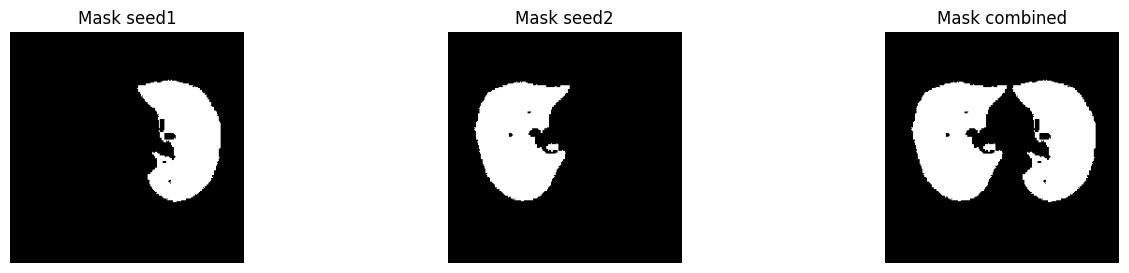

In [15]:
# row, col
seed1 = (100, 200)
seed2 = (100, 100)
tol = 0
mask_auto1 = flood(chest, seed1, tolerance=tol)
mask_auto2 = flood(chest, seed2, tolerance=tol)

mask_auto = np.logical_or(mask_auto1, mask_auto2).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))
axes[0].imshow(mask_auto1, cmap="gray")
axes[0].set_title("Mask seed1")
axes[0].axis("off")
axes[1].imshow(mask_auto2, cmap="gray")
axes[1].set_title("Mask seed2")
axes[1].axis("off")
axes[2].imshow(mask_auto, cmap="gray")
axes[2].set_title("Mask combined")
axes[2].axis("off")

## Tolerancia 20


(np.float64(-0.5), np.float64(249.5), np.float64(246.5), np.float64(-0.5))

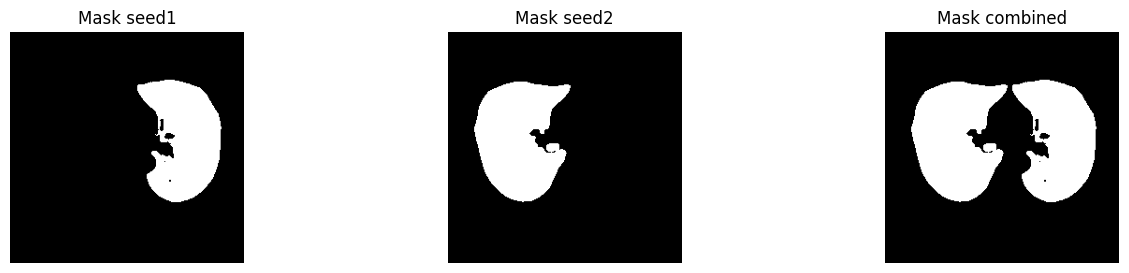

In [16]:
seed1 = (100, 200)
seed2 = (100, 100)
tol = 20
mask_auto1 = flood(chest, seed1, tolerance=tol)
mask_auto2 = flood(chest, seed2, tolerance=tol)

mask_auto_better = np.logical_or(mask_auto1, mask_auto2).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))
axes[0].imshow(mask_auto1, cmap="gray")
axes[0].set_title("Mask seed1")
axes[0].axis("off")
axes[1].imshow(mask_auto2, cmap="gray")
axes[1].set_title("Mask seed2")
axes[1].axis("off")
axes[2].imshow(mask_auto_better, cmap="gray")
axes[2].set_title("Mask combined")
axes[2].axis("off")

## Tolerancia 50


(np.float64(-0.5), np.float64(249.5), np.float64(246.5), np.float64(-0.5))

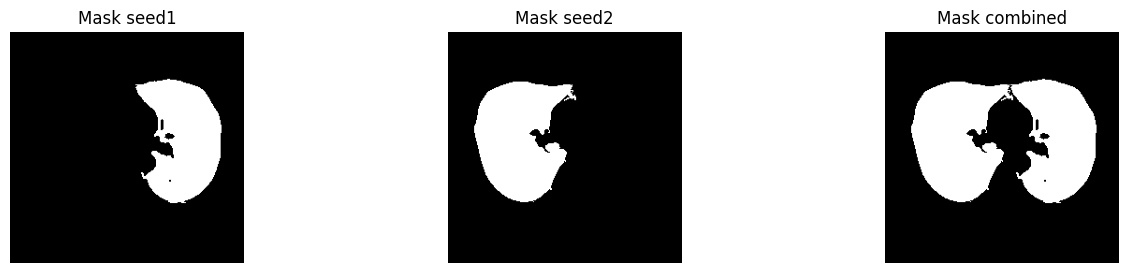

In [17]:
seed1 = (100, 200)
seed2 = (100, 100)
tol = 50
mask_auto1 = flood(chest, seed1, tolerance=tol)
mask_auto2 = flood(chest, seed2, tolerance=tol)

mask_auto = np.logical_or(mask_auto1, mask_auto2).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))
axes[0].imshow(mask_auto1, cmap="gray")
axes[0].set_title("Mask seed1")
axes[0].axis("off")
axes[1].imshow(mask_auto2, cmap="gray")
axes[1].set_title("Mask seed2")
axes[1].axis("off")
axes[2].imshow(mask_auto, cmap="gray")
axes[2].set_title("Mask combined")
axes[2].axis("off")

## Tolerancia 100


(np.float64(-0.5), np.float64(249.5), np.float64(246.5), np.float64(-0.5))

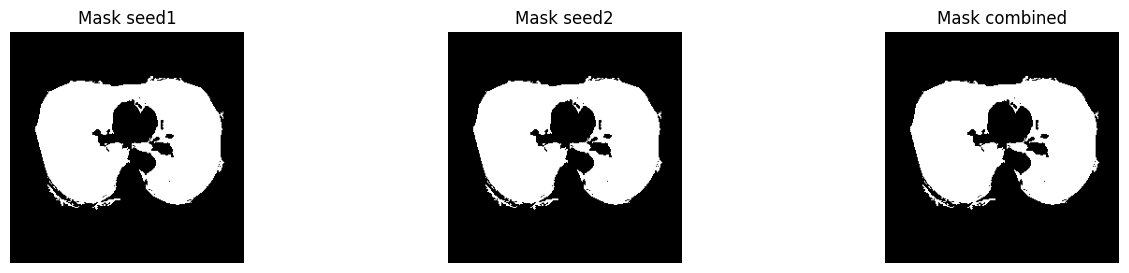

In [18]:
seed1 = (100, 200)
seed2 = (100, 100)
tol = 100
mask_auto1 = flood(chest, seed1, tolerance=tol)
mask_auto2 = flood(chest, seed2, tolerance=tol)

mask_auto = np.logical_or(mask_auto1, mask_auto2).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))
axes[0].imshow(mask_auto1, cmap="gray")
axes[0].set_title("Mask seed1")
axes[0].axis("off")
axes[1].imshow(mask_auto2, cmap="gray")
axes[1].set_title("Mask seed2")
axes[1].axis("off")
axes[2].imshow(mask_auto, cmap="gray")
axes[2].set_title("Mask combined")
axes[2].axis("off")

¿Cómo se puede determinar cualitativamente dos regiones?

Usamos diferentes tolerancias, y cualitativamente vemos que en tolerancias altas comienzan a aparecer artefactos que no corresponden a la entidad siendo segmentada. Ademas hay algo importante que decir, es que los pulmones en la imagen objetivo son en su mayoria de color negro, y bien definidos. Por lo cual nos bastaria una tolerancia baja. Luego al comparar la tolerancia de 0 y de 20 vemos el fenomeno que en partes del pulmon hay huecos los cuales no son visibles en la imagen original, y con la tolerancia de 20 los eliminamos.

¿Cuál segmentación tiene mejor calidad?

En este caso concluimos que la segmentacion que nos dio con mejor calidad experimentando es el de 20, donde vemos que se delimita correctamente el pulmon y no vemos artefactos visibles.


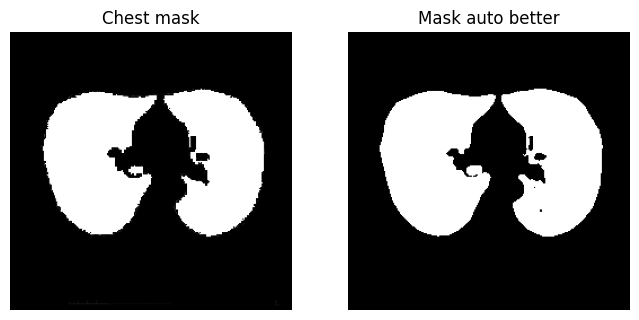

In [19]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(chest_mask, cmap="gray")
axes[0].set_title("Chest mask")
axes[0].axis("off")

axes[1].imshow(mask_auto_better, cmap="gray")
axes[1].set_title("Mask auto better")
axes[1].axis("off")
plt.show()

In [20]:
def dice_coefficient(mask1, mask2, smooth=1e-6):
    m1 = np.asarray(mask1).astype(bool)
    m2 = np.asarray(mask2).astype(bool)

    intersection = np.logical_and(m1, m2).sum()

    return (2.0 * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [21]:
d_coeff = dice_coefficient(mask_auto_better, chest_mask)

print(f"Dice Coefficient: {d_coeff:.4f}")

Dice Coefficient: 0.9779


¿Cómo puede interpretar el resultado?¿Respalda el análisis cualitativo el valor obtenido?

El coeficiente de Sorensen-Dice nos ayuda a medir la similitud entre 2 muestras. Lo que hacemos es pasarle la mascara que creamos manualmente y la mascara que creamos mediante el algoritmo de crecimiento de regiones (flooding). Y esto nos da alrededor de 97.79% de similitud.

Para finalizar podemos ver que son muy cercanos y concuerda con nuestro analisis cuantitativo.


## Ejercicio 3


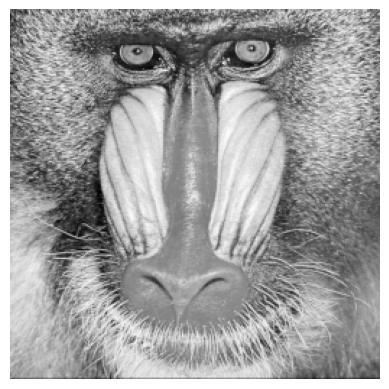

In [22]:
img_3 = [
    Path("./img/3-grouping/baboon.png"),
]
baboon_img = cv.imread(img_3[0], cv.IMREAD_GRAYSCALE)
plt.imshow(baboon_img, cmap="gray")
plt.axis("off")
plt.show()

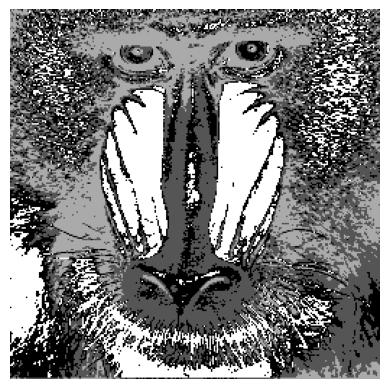

In [23]:
N, M = baboon_img.shape
img_flat = baboon_img.reshape(N * M, 1)
model_kmeans = KMeans(n_clusters=4, random_state=42)
baboon_segmented = model_kmeans.fit_predict(img_flat).reshape(N, M, 1)
plt.imshow(baboon_segmented, cmap="gray")
plt.axis("off")
plt.show()

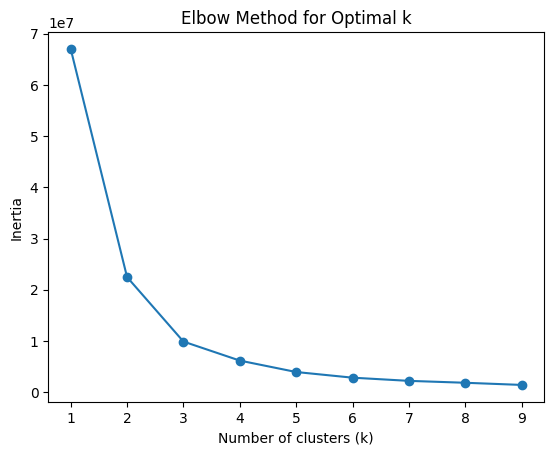

In [24]:
# elbow method
inertia = []
for k in range(1, 10):
    model_kmeans = KMeans(n_clusters=k, random_state=42)
    model_kmeans.fit(img_flat)
    inertia.append(model_kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

Al ver la gráfica, parece ser que el $K$ óptimo es $K=3$.


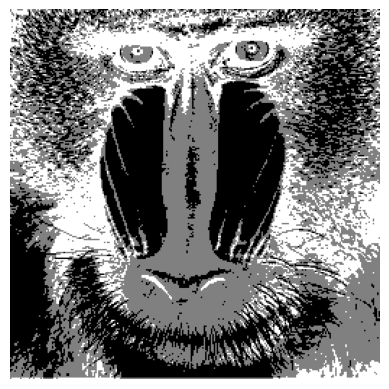

In [25]:
N, M = baboon_img.shape
K = 3
img_flat = baboon_img.reshape(N * M, 1)
model_kmeans = KMeans(n_clusters=K, random_state=42)
baboon_segmented = model_kmeans.fit_predict(img_flat).reshape(N, M, 1)
plt.imshow(baboon_segmented, cmap="gray")
plt.axis("off")
plt.show()

Al realizar la nueva segmentación, ahora con $K=3$, encontramos que la imágen tiene un mejor contraste. Gracias a esto, es más fácil identificar que se trata de baboon. Antes, cuando $K=4$, los dos grises de la mitad se parecían mucho y estaban ubicados contiguamente, quitándo contraste.

---


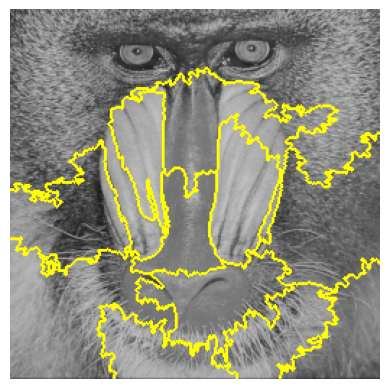

In [26]:
segments = slic(cv.merge([baboon_img, baboon_img, baboon_img]), n_segments=25)
plt.imshow(
    segmentation.mark_boundaries(
        cv.merge([baboon_img, baboon_img, baboon_img]), segments
    )
)
plt.axis("off")
plt.show()


In [27]:
num_superpixels = len(np.unique(segments))
print(num_superpixels)

12


Se encontraron $12$ superpixeles, al usar 25 segmentos.

---

Según lo que entiendo del enunciado 3.6 debemos generar una segmentación que encuentre $K$ grupos, luego una que encuentre $4*K$ y $10*K$. El método de superpíxeles SLIC no permite seleccionar $K$ directamente. Solo el número de segmentos. Debemos entonces buscar los valores de `n_segments` que generen los $K$ deseados.


In [28]:
wished_k = [K, 4 * K, 10 * K]
segments_k = []
for i in range(1, 100):
    segments = slic(cv.merge([baboon_img, baboon_img, baboon_img]), n_segments=i)
    if len(np.unique(segments)) in wished_k:
        segments_k.append(segments)
        print(len(np.unique(segments)))
        wished_k.remove(len(np.unique(segments)))
        print(wished_k)
    if len(wished_k) == 0:
        break

12
[3, 30]


In [29]:
len(segments_k)

1

Solo pudimos encontrar los segmentos que generan $4*K$ grupos. El resultado se puede ver a continuación


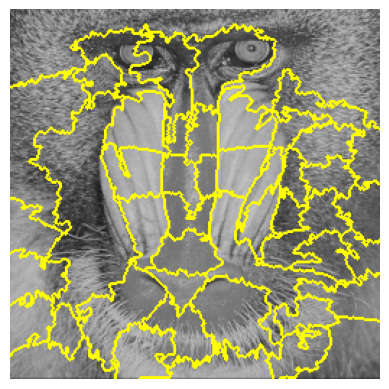

In [30]:
plt.imshow(
    segmentation.mark_boundaries(
        cv.merge([baboon_img, baboon_img, baboon_img]), segments
    )
)
plt.axis("off")
plt.show()


Pero no pudimos encontrar agrupaciones para $K$ y $K*10$ grupos. Por si estoy entendiendo el enunciado mal, también haré suponiendo que se refería a $K= \text{n segments}$ .


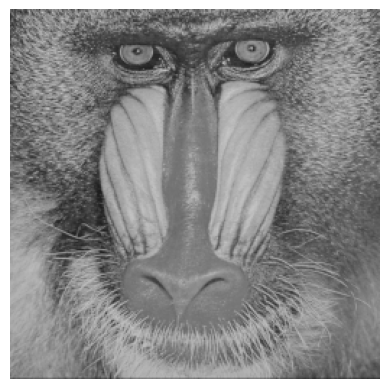

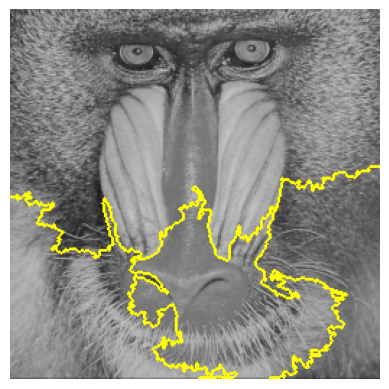

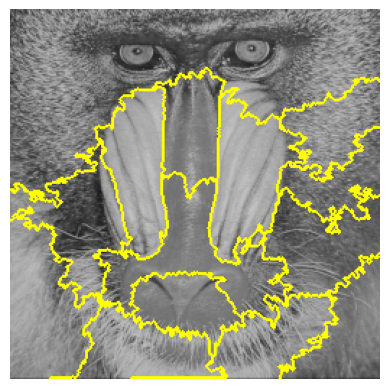

In [31]:
wished_k = [K, 4 * K, 10 * K]
for i in wished_k:
    segments = slic(cv.merge([baboon_img, baboon_img, baboon_img]), n_segments=i)
    plt.imshow(
        segmentation.mark_boundaries(
            cv.merge([baboon_img, baboon_img, baboon_img]), segments
        )
    )
    plt.axis("off")
    plt.show()

En cualquiera de los dos casos, se evidencia que el algoritmo de K means realiza agrupaciones muy diferentes a las de superpixeles.

Esto se debe a que los dos funcionan diferente. Mientras K_Means funciona exclusivamente con el valor de gris del pixel, el algoritmo slic también tiene en cuenta los pixeles contiguos.

Debido a que funcionan de manera diferente, depende de la tarea deseada el que uno sea mejor que el otro. Si se pretendiera segmentar la imagen, diría que SLIC, pero si se pretende cambiar los colores de la imágen, K_Means.
